# Demo of graph optimisation on real graph to segment structures:

# TODO: implement edge classification predictions just as in the dummy graph:

In [1]:
import os

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np


In [2]:
import torch
import torch_geometric

from scipy.special import softmax


In [3]:
from grace.base import GraphAttrs, Annotation

# from grace.simulator.simulate_graph import random_graph, random_graph_mixed_motifs
from grace.simulator.simulate_image import montage_from_image
from grace.models.datasets import dataset_from_graph
from grace.models.optimise import optimise_graph

from grace.io.image_dataset import ImageGraphDataset
from grace.models.feature_extractor import FeatureExtractor


### Load an example image + build graph:

In [4]:
# IMAGE_DIR = "/Users/kulicna/Desktop/classifier/data_real/"
IMAGE_DIR = "/Users/kulicna/Desktop/classifier/data_fake/infer/padded/"
IMAGE_DIR, os.path.isdir(IMAGE_DIR)

('/Users/kulicna/Desktop/classifier/data_fake/infer/padded/', True)

In [5]:
image_graph_dataset = ImageGraphDataset(
    image_dir=IMAGE_DIR,
    grace_dir=IMAGE_DIR,
    transform=lambda x,y: (x,y),
    image_filetype="mrc",
)
image_graph_dataset

In [6]:
for image, graph_data in image_graph_dataset:
    image = image.T
    print (image.shape, graph_data.keys(), graph_data)


torch.Size([3948, 3948]) dict_keys(['graph', 'metadata']) {'graph': <networkx.classes.graph.Graph object at 0x7fee59c8da80>, 'metadata': {'image_filename': 'MRC_Synthetic_File_000'}}


In [7]:
image.dtype, image.max(), image.min()

(torch.float32, tensor(1.), tensor(0.))

In [8]:
graph = graph_data['graph']
graph.number_of_nodes(), graph.number_of_edges()


(170, 495)

In [9]:
single_node = graph.nodes()[0]
single_node

{<GraphAttrs.NODE_X: 'x'>: 1652.398193359375,
 <GraphAttrs.NODE_Y: 'y'>: 1205.2373046875,
 <GraphAttrs.NODE_CONFIDENCE: 'confidence'>: nan,
 <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>: <Annotation.TRUE_NEGATIVE: 0>,
 <GraphAttrs.NODE_FEATURES: 'features'>: None}

In [10]:
pos = {idx: [node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]] for idx, node in graph.nodes(data=True)}
len(pos)

170

In [11]:
coords_x, coords_y = np.transpose(list(pos.values()))
coords_x.shape, coords_y.shape

((170,), (170,))

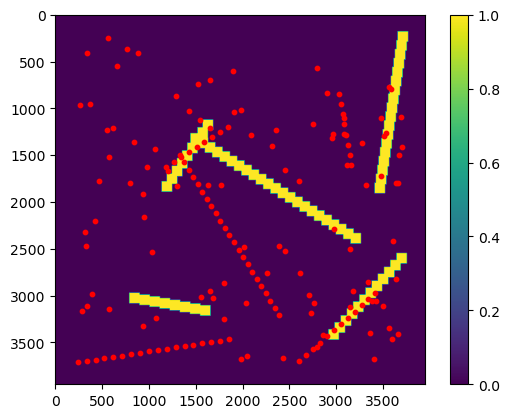

In [12]:
# plt.imshow(image, cmap="binary_r")
plt.imshow(image)
plt.colorbar()
plt.scatter(coords_x, coords_y, color='red', s=10)
plt.show()

### Divide by labels:

In [13]:
node_coords = [[] for _ in range(3)]

for idx, node in graph.nodes.data():
    coords = node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]

    label = node[GraphAttrs.NODE_GROUND_TRUTH]
    node_coords[label].append(coords)

[]

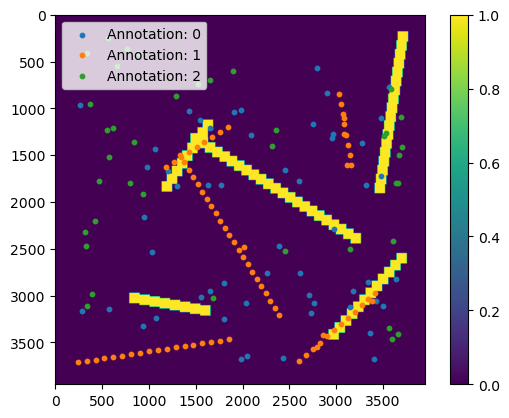

In [14]:
plt.imshow(image)
plt.colorbar()
for group_idx in range(len(node_coords)):
    group_data = node_coords[group_idx]
    group_data = np.array(group_data)
    plt.scatter(x=group_data[:, 0], y=group_data[:, 1], 
                s=10, label=f"Annotation: {group_idx}")
plt.legend(loc="upper left")
plt.plot()


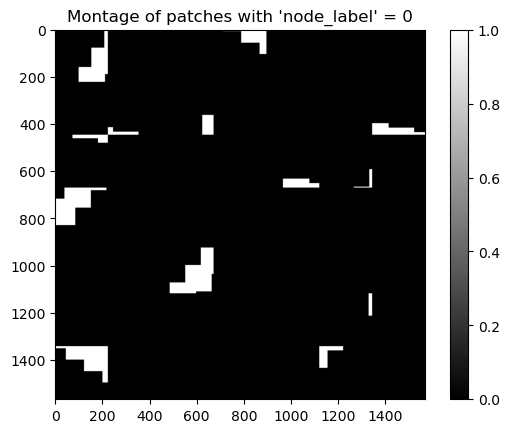

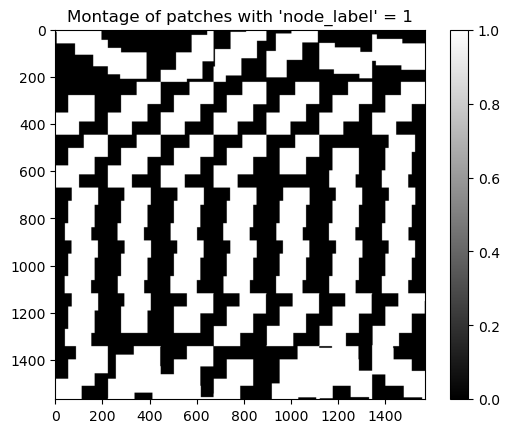

In [15]:
montage_from_image(G=graph, image=image, crop_shape=(224, 224))

### Now extract the features from each node patch:

In [16]:
feature_extractor = torch.load("/Users/kulicna/Desktop/classifier/extractor/resnet152.pt")
feature_extractor = FeatureExtractor(model=feature_extractor)
feature_extractor

FeatureExtractor(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

In [17]:
image, graph = feature_extractor(image=image, graph=graph_data)
type(image), type(graph)

/Users/kulicna/anaconda3/envs/grace-environment/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Tensor, dict)

### Each node now has the feature vector appended to it:

In [18]:
graph = graph['graph']
single_node = graph.nodes()[0]
single_node, single_node[GraphAttrs.NODE_FEATURES].shape

({<GraphAttrs.NODE_X: 'x'>: 1652.398193359375,
  <GraphAttrs.NODE_Y: 'y'>: 1205.2373046875,
  <GraphAttrs.NODE_CONFIDENCE: 'confidence'>: nan,
  <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>: <Annotation.TRUE_NEGATIVE: 0>,
  <GraphAttrs.NODE_FEATURES: 'features'>: tensor([0.7883, 0.4519, 0.8646,  ..., 0.4348, 0.4147, 0.4389])},
 torch.Size([2048]))

In [19]:
node_GT = [0 for _ in range(3)]

for _, node in graph.nodes.data():
    node_GT[node[GraphAttrs.NODE_GROUND_TRUTH]] += 1

node_GT

[54, 77, 39]

In [20]:
edge_GT = [0 for _ in range(3)]

for st, en, edge in graph.edges.data():
    edge_GT[edge[GraphAttrs.EDGE_GROUND_TRUTH]] += 1

edge_GT

[190, 93, 212]

## Now run inference:

### Load the pre-trained models for node & edge classification:

In [21]:
classifier_model = torch.load("/Users/kulicna/Desktop/classifier/runs/2023-06-20_17-32-38/classifier.pt")
classifier_model

GCN(
  (conv1): GCNConv(2048, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (node_classifier): Linear(in_features=32, out_features=2, bias=True)
  (edge_classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [22]:
def get_node_predictions(G, model):
    model.eval()
    anno = G.nodes.data()
    print (anno)

    predictions = []
    dataset = dataset_from_graph(G, n_hop=1, in_train_mode=False)
    print (G.number_of_nodes(), G.number_of_edges())
    print (len(dataset))

    for data in dataset:  # Iterate in batches over the training/test dataset.
        # print (data.x.shape, data.edge_index, data.edge_index.shape)
        out = model(data.x, data.edge_index)
        # print ('outs', out[0].shape, out[1].shape)
        out = out[0]  # because it's only nodes at this point you care about! out[1] = edges
        # print (out)
        pred = out.argmax(dim=1)
        # print (pred)
        probs = softmax(out.detach().numpy())
        # print (probs)
        predictions.append((int(pred.numpy()), probs))

    # this is the prediction that the node is in the object
    for (_, node), prediction in zip(G.nodes.data(), predictions):
        # for a FP, we want this to be the prob that it's *NOT* in the object
        # print("pred", pred, pred[1].shape)
        
        node[GraphAttrs.NODE_PREDICTION] = np.clip(float(prediction[1][0, 0]), 0, 1)
        # node[GraphAttrs.NODE_PREDICTION] = np.clip(float(prediction[1][0, 1]), 0, 1)
        # node[GraphAttrs.NODE_PREDICTION] = prediction[0]

    return G


In [23]:
graph = get_node_predictions(graph, classifier_model)
graph


[(0, {<GraphAttrs.NODE_X: 'x'>: 1652.398193359375, <GraphAttrs.NODE_Y: 'y'>: 1205.2373046875, <GraphAttrs.NODE_CONFIDENCE: 'confidence'>: nan, <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>: <Annotation.TRUE_NEGATIVE: 0>, <GraphAttrs.NODE_FEATURES: 'features'>: tensor([0.7883, 0.4519, 0.8646,  ..., 0.4348, 0.4147, 0.4389])}), (1, {<GraphAttrs.NODE_X: 'x'>: 266.4964599609375, <GraphAttrs.NODE_Y: 'y'>: 965.4627075195312, <GraphAttrs.NODE_CONFIDENCE: 'confidence'>: nan, <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>: <Annotation.TRUE_NEGATIVE: 0>, <GraphAttrs.NODE_FEATURES: 'features'>: tensor([0.8441, 0.5116, 0.9694,  ..., 0.4165, 0.3202, 0.4333])}), (2, {<GraphAttrs.NODE_X: 'x'>: 3317.171630859375, <GraphAttrs.NODE_Y: 'y'>: 1817.8016357421875, <GraphAttrs.NODE_CONFIDENCE: 'confidence'>: nan, <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>: <Annotation.TRUE_NEGATIVE: 0>, <GraphAttrs.NODE_FEATURES: 'features'>: tensor([0.8251, 0.4597, 0.7760,  ..., 0.3708, 0.3127, 0.3567])})

AttributeError: 'tuple' object has no attribute 'x'

In [ ]:
def dataset_from_whole_graph(
    graph: nx.Graph, *, n_hop: int = 1, is_constrained: bool = True,
) -> list[torch_geometric.data.Data]:
    """Create a pytorch geometric dataset from a give networkx graph.

    Parameters
    ----------
    graph : graph
        A networkx graph.
    n_hop : int
        The number of hops from the central node when creating the subgraphs.

    Returns
    -------
    dataset : list
        A list of pytorch geometric data objects representing the extracted
        subgraphs.
    """

    # dataset = []

    sub_graph = graph
    edge_label = [
        edge[GraphAttrs.EDGE_GROUND_TRUTH]
        for _, _, edge in sub_graph.edges(data=True)
    ]

    x = np.stack(
        [
            node[GraphAttrs.NODE_FEATURES]
            for _, node in sub_graph.nodes(data=True)
        ],
        axis=0,
    )

    pos = np.stack(
        [
            (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y])
            for _, node in sub_graph.nodes(data=True)
        ],
        axis=0,
    )

    # TODO: edge attributes
    # central_node = np.array(
    #     [values[GraphAttrs.NODE_X], values[GraphAttrs.NODE_Y]]
    # )
    # edge_attr = pos - central_node

    item = nx.convert_node_labels_to_integers(sub_graph)
    edges = list(item.edges)
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    data = torch_geometric.data.Data(
        x=torch.Tensor(x),
        edge_index=edge_index,
        # edge_attr=torch.Tensor(edge_attr),
        edge_label=torch.Tensor(edge_label).long(),
        pos=torch.Tensor(pos),
        # y=torch.as_tensor([values[GraphAttrs.NODE_GROUND_TRUTH]]),
    )

    # dataset.append(data)

    # return dataset

    return data


In [ ]:
def get_edge_predictions(G, model):
    model.eval()
    
    predictions = []
    dataset_single_batch = dataset_from_graph(G, n_hop=1, in_train_mode=False)
    print (G.number_of_nodes(), G.number_of_edges())
    print (len(dataset_single_batch))
    print (dataset_single_batch)

    data = dataset_single_batch
    print (data.x.shape, data.edge_index, data.edge_index.shape)
    out = model(data.x, data.edge_index)
    print ('outs', out[0].shape, out[1].shape)
    out = out[1]  # because it's only edges at this point you care about! out[1] = edges
    print ("out[1]", out.shape)
    pred = out.argmax(dim=1)
    print ("pred", pred.shape)
    probs = softmax(out.detach().numpy())
    print ("probs", probs.shape)
    # predictions.append((int(pred.numpy()), probs))
    
    predictions = {}
    for e in range(data.edge_index.shape[-1]):
        src_node_idx = data.edge_index[0][e].int().numpy()
        tgt_node_idx = data.edge_index[1][e].int().numpy()
        predictions[f"{src_node_idx}-{tgt_node_idx}"] = np.clip(float(probs[e, 0]), 0, 1)
        # predictions[f"{src_node_idx}-{tgt_node_idx}"] = np.clip(float(probs[e, 1]), 0, 1)
        # predictions[f"{src_node_idx}-{tgt_node_idx}"] = pred[e].detach().numpy()
        
    print ("predictions", predictions)
    # predictions = (pred.int().numpy(), probs)
    # print ("predictions", predictions[0].shape, predictions[1].shape)

    print ("HERE!")

    print (data.x.shape, data.edge_index, data.edge_index.shape)
    print (G.edges.data())

    for src, tgt, edge in G.edges.data():
        # src, tgt, attribs = edge
        print (predictions[f"{src}-{tgt}"])
        edge[GraphAttrs.EDGE_PREDICTION] = predictions[f"{src}-{tgt}"]
        
        
    # # this is the prediction that the node is in the object
    # for (something, edge), prediction in zip(G.edges.data(), predictions):
    #     print (something, edge)
    #     # for a FP, we want this to be the prob that it's *NOT* in the object
    #     # print("pred", pred, pred[1].shape)
    #     edge[GraphAttrs.EDGE_PREDICTION] = np.clip(float(prediction[1][0, 0]), 0, 1)

    return G


In [ ]:
graph = get_edge_predictions(graph, classifier_model)
graph


170 495
1
[Data(x=[170, 2048], edge_index=[2, 495], edge_attr=[170, 2], y=[1], pos=[170, 2], edge_label=[495])]


AttributeError: 'list' object has no attribute 'x'

### Ok, we've appended the prediction values to each element (all nodes and edges)

### Plot the predictions of the model:

In [ ]:
# nodes_true = [single_node[1][GraphAttrs.NODE_GROUND_TRUTH] for single_node in graph.nodes.data()]
# edges_true = [single_edge[2][GraphAttrs.EDGE_GROUND_TRUTH] for single_edge in graph.edges.data()]

# nodes_pred = [single_node[1][GraphAttrs.NODE_PREDICTION] for single_node in graph.nodes.data()]
# edges_pred = [single_edge[2][GraphAttrs.EDGE_PREDICTION] for single_edge in graph.edges.data()]

# len(nodes_true), len(edges_true), len(nodes_pred), len(edges_pred)

In [ ]:
# plt.hist(nodes_true, label="nodes_true")
# # plt.hist(nodes_pred, label="nodes_pred")
# # plt.hist(edges_true, label="edges_true")
# # plt.hist(edges_pred, label="edges_pred")
# plt.title(f"Prediction values | {len(nodes_pred)} NODES | {len(edges_pred)} EDGES")
# plt.legend()
# plt.show()

In [ ]:
nodes_TN_pred = [single_node[GraphAttrs.NODE_PREDICTION] for _, single_node in graph.nodes.data() if single_node[GraphAttrs.NODE_GROUND_TRUTH] == 0]
nodes_TP_pred = [single_node[GraphAttrs.NODE_PREDICTION] for _, single_node in graph.nodes.data() if single_node[GraphAttrs.NODE_GROUND_TRUTH] == 1]
len(nodes_TN_pred), len(nodes_TP_pred)

KeyError: <GraphAttrs.NODE_PREDICTION: 'node_prediction'>

In [ ]:
plt.hist(nodes_TN_pred, label="nodes_TN_pred")
plt.hist(nodes_TP_pred, label="nodes_TP_pred")
plt.title(f"Prediction values | {len(nodes_TN_pred)} NODES")
plt.legend()
plt.show()

NameError: name 'nodes_TN_pred' is not defined

In [ ]:
edges_TN_pred = [single_edge[GraphAttrs.EDGE_PREDICTION] for _, _, single_edge in graph.edges.data() if single_edge[GraphAttrs.EDGE_GROUND_TRUTH] == 0]
edges_TP_pred = [single_edge[GraphAttrs.EDGE_PREDICTION] for _, _, single_edge in graph.edges.data() if single_edge[GraphAttrs.EDGE_GROUND_TRUTH] == 1]
len(edges_TN_pred), len(edges_TP_pred)

KeyError: <GraphAttrs.EDGE_PREDICTION: 'edge_prediction'>

In [ ]:
plt.hist(edges_TN_pred, label="edges_TN_pred")
plt.hist(edges_TP_pred, label="edges_TP_pred")
plt.title(f"Prediction values | {len(edges_TN_pred)} EDGES")
plt.legend()
plt.show()

NameError: name 'edges_TN_pred' is not defined

# Optimise a real graph:

In [ ]:
x = optimise_graph(graph)

### Visualise the graph & individual objects:

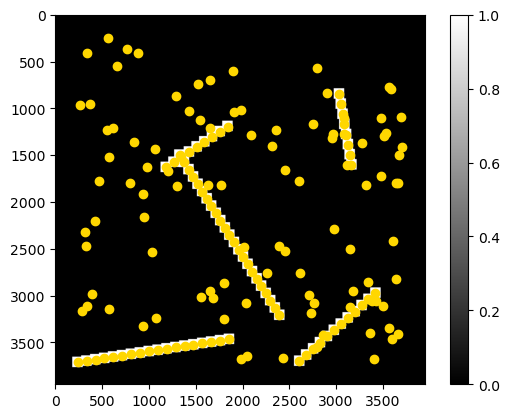

In [ ]:
plt.imshow(image, cmap="binary_r")
plt.colorbar()
plt.scatter(coords_x, coords_y, color='gold')
plt.show()

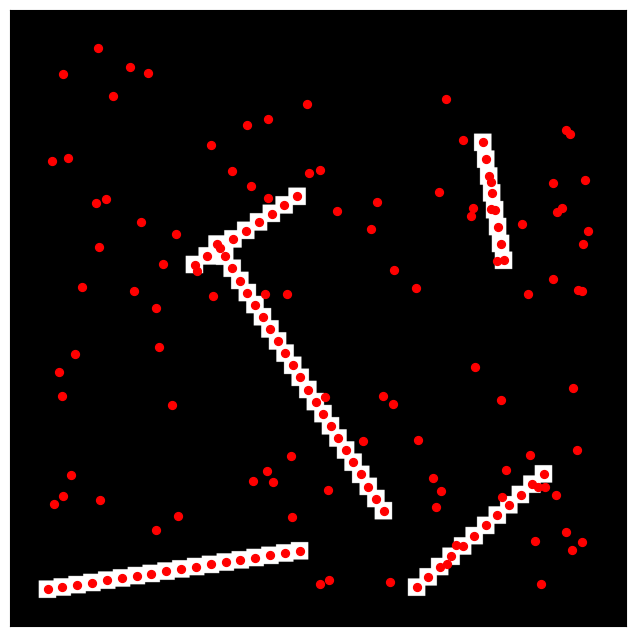

In [ ]:
pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in x.nodes(data=True)}
fig, ax = plt.subplots(figsize=(8, 8))

# draw all nodes/vertices in the graph, including those not determined to be part of the objects
plt.imshow(image, cmap="binary_r")
nx.draw_networkx(x, ax=ax, pos=pos, with_labels=False, node_color="r", node_size=32)
plt.show()


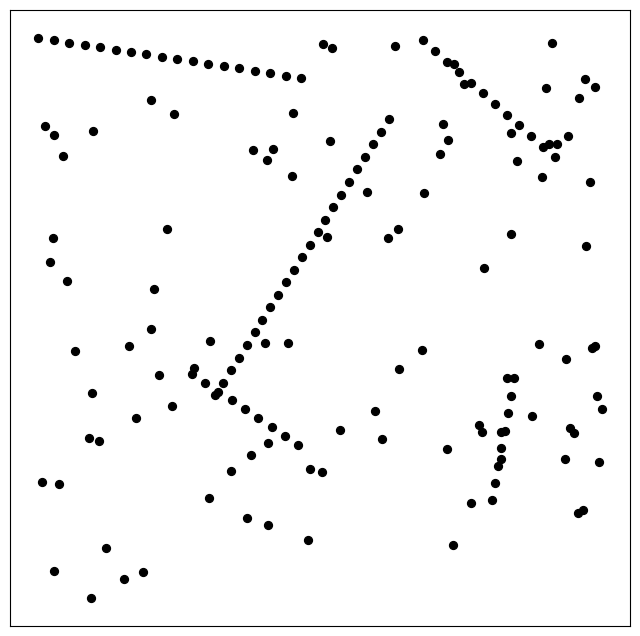

In [ ]:

# plt.ion()

pos = {idx: (node[GraphAttrs.NODE_X], node[GraphAttrs.NODE_Y]) for idx, node in x.nodes(data=True)}
fig, ax = plt.subplots(figsize=(8, 8))

# draw all nodes/vertices in the graph, including those not determined to be 
# part of the objects
nx.draw_networkx(x, ax=ax, pos=pos, with_labels=False, node_color="k", node_size=32)

# get each connected subgraph and draw it with a different colour
cc = nx.connected_components(x)
for index, sg in enumerate(cc):
    # print (index, sg)

    if len(sg) <= 1:
        continue

    c_idx = np.array(plt.cm.tab20((index % 20) / 20)).reshape(1, -1)
    sg = x.subgraph(sg).copy()
    plt.imshow(image, cmap="binary_r")
    nx.draw_networkx(sg, pos=pos, edge_color=c_idx, node_color=c_idx, with_labels=False)

plt.show()

### Done!

In [ ]:
# if update_graph:
    # graph.nodes[idx][
    #     GraphAttrs.NODE_GROUND_TRUTH
    # ] = Annotation.TRUE_POSITIVE


In [61]:
graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

In [62]:
graph.nodes[0]

{<GraphAttrs.NODE_X: 'x'>: 2389.09033203125,
 <GraphAttrs.NODE_Y: 'y'>: 1206.11669921875,
 <GraphAttrs.NODE_CONFIDENCE: 'confidence'>: nan,
 <GraphAttrs.NODE_GROUND_TRUTH: 'node_ground_truth'>: <Annotation.UNKNOWN: 2>,
 <GraphAttrs.NODE_FEATURES: 'features'>: tensor([0.7488, 0.5034, 0.8341,  ..., 0.4139, 0.3560, 0.4108]),
 <GraphAttrs.NODE_PREDICTION: 'node_prediction'>: 0.9999991655349731}

In [73]:
graph.edges()

EdgeView([(0, 51), (0, 172), (0, 171), (0, 48), (0, 57), (0, 66), (1, 72), (1, 202), (1, 201), (1, 15), (1, 88), (1, 68), (2, 49), (2, 3), (2, 100), (2, 56), (2, 5), (2, 79), (2, 74), (3, 145), (3, 144), (3, 79), (3, 74), (3, 143), (3, 147), (3, 146), (3, 38), (4, 11), (4, 10), (4, 64), (4, 31), (4, 26), (5, 101), (5, 100), (5, 67), (5, 102), (5, 79), (6, 169), (6, 173), (6, 172), (6, 32), (6, 115), (6, 55), (6, 59), (6, 171), (6, 170), (6, 114), (6, 80), (7, 124), (7, 96), (7, 85), (7, 188), (7, 187), (7, 29), (7, 126), (7, 125), (7, 186), (7, 60), (7, 190), (7, 189), (8, 9), (8, 32), (8, 52), (8, 33), (9, 99), (9, 52), (10, 31), (10, 94), (10, 19), (10, 64), (10, 73), (11, 64), (11, 26), (11, 151), (11, 77), (11, 150), (12, 198), (12, 207), (12, 90), (12, 202), (12, 197), (12, 206), (12, 201), (12, 210), (12, 196), (12, 25), (12, 61), (12, 93), (12, 205), (12, 200), (12, 209), (12, 204), (12, 199), (12, 208), (12, 203), (13, 69), (13, 73), (13, 48), (13, 66), (13, 19), (14, 24), (14,

In [79]:
# for edge in graph.edges():
#     source, target = edge
#     print (source, target, edge) 
#     # print (graph[source][target][GraphAttrs.EDGE_GROUND_TRUTH])

#     edge_label = graph[source][target][GraphAttrs.EDGE_GROUND_TRUTH]
#     print (edge_label)

#     source_label = graph.nodes[source][GraphAttrs.NODE_GROUND_TRUTH]
#     target_label = graph.nodes[target][GraphAttrs.NODE_GROUND_TRUTH]
#     print (source_label, target_label)

#     # for the cut edges, label the 'outside' nodes as true negatives:
#     if edge_label == Annotation.TRUE_NEGATIVE:
#         if source_label == Annotation.UNKNOWN:
#             graph.nodes[source][GraphAttrs.NODE_GROUND_TRUTH] == Annotation.TRUE_NEGATIVE
#         if target_label == Annotation.UNKNOWN:
#             graph.nodes[target][GraphAttrs.NODE_GROUND_TRUTH] == Annotation.TRUE_NEGATIVE



0 51 (0, 51)
Annotation.UNKNOWN
Annotation.UNKNOWN Annotation.UNKNOWN
0 172 (0, 172)
Annotation.TRUE_NEGATIVE
Annotation.UNKNOWN Annotation.TRUE_POSITIVE
0 171 (0, 171)
Annotation.TRUE_NEGATIVE
Annotation.UNKNOWN Annotation.TRUE_POSITIVE
0 48 (0, 48)
Annotation.UNKNOWN
Annotation.UNKNOWN Annotation.UNKNOWN
0 57 (0, 57)
Annotation.UNKNOWN
Annotation.UNKNOWN Annotation.UNKNOWN
0 66 (0, 66)
Annotation.UNKNOWN
Annotation.UNKNOWN Annotation.UNKNOWN
1 72 (1, 72)
Annotation.UNKNOWN
Annotation.UNKNOWN Annotation.UNKNOWN
1 202 (1, 202)
Annotation.TRUE_NEGATIVE
Annotation.UNKNOWN Annotation.TRUE_POSITIVE
1 201 (1, 201)
Annotation.TRUE_NEGATIVE
Annotation.UNKNOWN Annotation.TRUE_POSITIVE
1 15 (1, 15)
Annotation.UNKNOWN
Annotation.UNKNOWN Annotation.UNKNOWN
1 88 (1, 88)
Annotation.TRUE_NEGATIVE
Annotation.UNKNOWN Annotation.TRUE_POSITIVE
1 68 (1, 68)
Annotation.UNKNOWN
Annotation.UNKNOWN Annotation.UNKNOWN
2 49 (2, 49)
Annotation.UNKNOWN
Annotation.UNKNOWN Annotation.UNKNOWN
2 3 (2, 3)
Annotation.

In [65]:
for i in range(len(graph.nodes)):
    e = graph.edges(graph.nodes[i])
    print (e)

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
